In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

#plt show
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# DataLoader - num_workers


```
num_workers (int, optional) – how many subprocesses to use for data loading. 
      0 means that the data will be loaded in the main process. (default: 0)
```

data 로딩을 위해 몇개의 서브 프로세스를 사용할 것인가? 즉, **데이터 로드 멀티 프로세싱**에 관한 얘기입니다.

당연히 무조건 늘리면 좋은 것은 아니고 CPU-GPU 작업간의 밸런스를 적절히 유지하기 위해 튜닝을 해야합니다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdeYFIB%2FbtqvBMyvG8Q%2FMYusVmKLRoXexAwPC0Juq0%2Fimg.png)

위 그림의 빨강색 선이 길어질수록 GPU util이 낮아집니다.

따라서, 위의 전처리과정(보라색선)을 통해 CPU가 태스크를 GPU로 바로 준다면 좋아질 것입니다.

적절히 튜닝을 하는 방법은 GPU,CPU 개수, I/O 속도, 메모리 등을 고려하여 조절합니다.

관련한 discuss에 대한 [링크](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813)를 읽어봅시다.

**일반적으로 코어 개수의 절반정도 수치면 무난하게 시스템 리소스를 사용하며 학습이 가능**하다고 합니다.

## Reference

- https://jybaek.tistory.com/799


In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


cuda:0


In [6]:
print(image_datasets)
print()
print(dataloaders)
print(dataset_sizes)
print(class_names)


{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data\val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}

{'train': <torch.utils.data.dataloader.DataLoader object at 0x000002ADFD82B640>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x000002ADFD82B5B0>}
{'train': 244, 'val': 153}
['

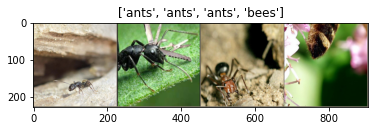

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # criterion은 logits의 의미
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계 ( running_loss = 한 에폭당 손실 합, running_corrects = 한 에폭당 맞은 갯수 )
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} original:{}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\CHOISJ-DT01/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5985 Acc: 0.7049
val Loss: 0.1930 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4607 Acc: 0.7992
val Loss: 0.2198 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.5627 Acc: 0.7746
val Loss: 0.5425 Acc: 0.7647

Epoch 3/24
----------
train Loss: 0.3782 Acc: 0.8402
val Loss: 0.2819 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.2798 Acc: 0.9098
val Loss: 0.3752 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.6302 Acc: 0.7623
val Loss: 0.4696 Acc: 0.8235

Epoch 6/24
----------
train Loss: 0.4670 Acc: 0.8197
val Loss: 0.2244 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.2886 Acc: 0.8730
val Loss: 0.1938 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3674 Acc: 0.8566
val Loss: 0.2001 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2420 Acc: 0.8934
val Loss: 0.2139 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3674 Acc: 0.8525
val Loss: 0.1865 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2811 Acc: 0.8852
val Loss: 0.1858 Acc: 0.9216

Epoch 12/24
----------
t

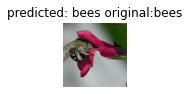

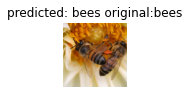

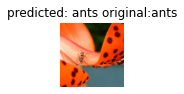

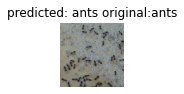

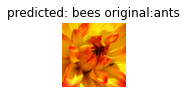

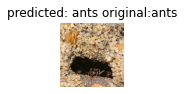

In [16]:
visualize_model(model_ft)

# Transfer Learning

backbone 네트워크를 freeze하는 전략

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FH4rr7%2FbtqvBNchX4H%2FRmikaKBNm2N6VYD9JbI800%2Fimg.png)

1. full-unfreeze
    - 큰 사이즈의 데이터셋이 필요
    
2. part-freeze
    - 데이터셋이 작고 모델의 파라미터가 많을 때 적은양의 계층을 학습
    
3. full-freeze
    - 데이터셋이 너무 작을 때나 새로운 문제가 이전 모델이 이미 학습한 데이터셋과 매우 비슷할때


In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
    
    
# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7311 Acc: 0.5902
val Loss: 0.2381 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.3767 Acc: 0.8279
val Loss: 0.1893 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.6412 Acc: 0.6885
val Loss: 0.1767 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.5123 Acc: 0.7910
val Loss: 0.1811 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4406 Acc: 0.8320
val Loss: 0.2236 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4720 Acc: 0.7951
val Loss: 0.2117 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4904 Acc: 0.7828
val Loss: 0.1797 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4798 Acc: 0.7992
val Loss: 0.1818 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4708 Acc: 0.8197
val Loss: 0.1783 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3983 Acc: 0.8156
val Loss: 0.1766 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.4461 Acc: 0.7869
val Loss: 0.1863 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3671 Acc: 0.8197
val Loss: 0.2081 Acc: 0.9477

Ep

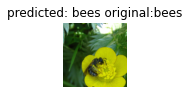

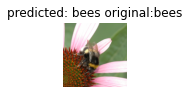

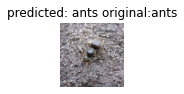

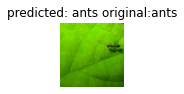

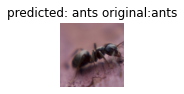

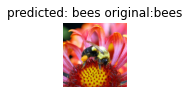

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()